# Basic Transfer Learning

Here I will demonstrate how to do basic transfer learning with tensorflow and keras. The bottom layer of our neural network will use a feature vector extracted from a much more complex convolutional neural network.  

## 1) Imports: 

We use tensorflow (tf) with keras to build and train our models. 

We use tensorflow_hub (hub) which connects to a library of reusable machine learning model components called modules which can be viewed here: https://tfhub.dev/. From here we will extract a pretrained feature layer which will transfer to our model. 

Similarly, we use tensorflow_datasets (tfds) which connects to a collection of datasets ready to use with tensorflow: https://www.tensorflow.org/datasets/catalog/overview. 

We will use matplotlib.pyplot (plt) to plot our learning curves. 

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

## 2) Setup and validate the GPUs:

Here we prepare the GPUs for use and confirm they are avaialable to tensorflow. Note memory growth must be set before GPUs have been initialized and that memory growth needs to be the same across GPUs. 

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)


1 Physical GPUs, 1 Logical GPUs


## 3) Load dataset:

Here we load in The Oxford-IIIT Pet Dataset found here: https://www.tensorflow.org/datasets/catalog/oxford_iiit_pet. 

The Oxford-IIIT Pet Dataset is an image dataset of 37 breeds of cats and dogs with around 200 images for each breed. The images vary in scale, pose and lighting. The dataset also consists of the corresponding label for each image and a pixel-wise mask for image segmentation. 

tfds.load is a convenience method that's the simplest way to build and load a tf.data.Dataset when it is registered in the Tensorflow datasets collection. When with_info=True a tuple is returned that contains both the dataset and a tfds.core.DatasetInfo object which contains useful metadata on the dataset. 

Each dataset comes in it's own format which you may have to explore. In this case our dataset is actually two tf.data.Dataset's specified in a dicitonary as the train and test splits. Each split contains the images, labels, file names and segmentation masks. 

Note when we load we could set as_supervised to true and the dataset will have a 2-tuple structure of (image, label) and remove all the other data we aren't using. However in this case the info object does not include a feature dictionary from label to human-readable string so we must infer it ourselves from the dataset directly where a file_name is associated with each label.

In [4]:
dataset, info = tfds.load('oxford_iiit_pet', with_info=True)

raw_train = dataset['train']
raw_test = dataset['test']

## 4) Prepare input pipeline:

Here we prepare our input pipeline for training. Most importantly we format our dataset as a 2-tuple structure of (image, label), resize the images so they all have the same dimensions, and then batch the (image, label) tuples into groups of 34. This is applied to both the train and the test splits.

For the training data we also augment our dataset by randomly flipping images left and right. This effectively increases the size of our training set. We also shuffle and repeat the input pipeline where the batches and the augmentations are randomly re-applied each iteration. 

In [5]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = info.splits['train'].num_examples

train = raw_train.map(
    lambda datapoint: (datapoint['image'], datapoint['label'])
).map(
    lambda image, label: (tf.image.convert_image_dtype(image, tf.float32), label)
).map(
    lambda image, label: (tf.image.resize(image, IMG_SIZE), label)
).map(
    lambda image, label: (tf.image.random_flip_left_right(image), label)
).cache().shuffle(
    SHUFFLE_BUFFER_SIZE
).batch(
    BATCH_SIZE
).repeat()

test = raw_test.map(
    lambda datapoint: (datapoint['image'], datapoint['label'])
).map(
    lambda image, label: (tf.image.convert_image_dtype(image, tf.float32), label)
).map(
    lambda image, label: (tf.image.resize(image, IMG_SIZE), label)
).batch(
    BATCH_SIZE
)

## 5) View and validate images in pipeline:

It's good to sanity check our input pipeline to make sure the images and labels are what we expect. 

First we want to create a dictionary to map from labels to human-readable strings. We can infer this from the file names contained in the original raw dataset. Next we want to display a number of images along with their breed.

I'm not personally an expert on dog and cat breeds but notice a breed starting with a capital letter indicates the species is a cat and lowercase indicates the species is a dog. Combine that knowledge with the few cat and dog breeds I am familiar with and all seems well. 

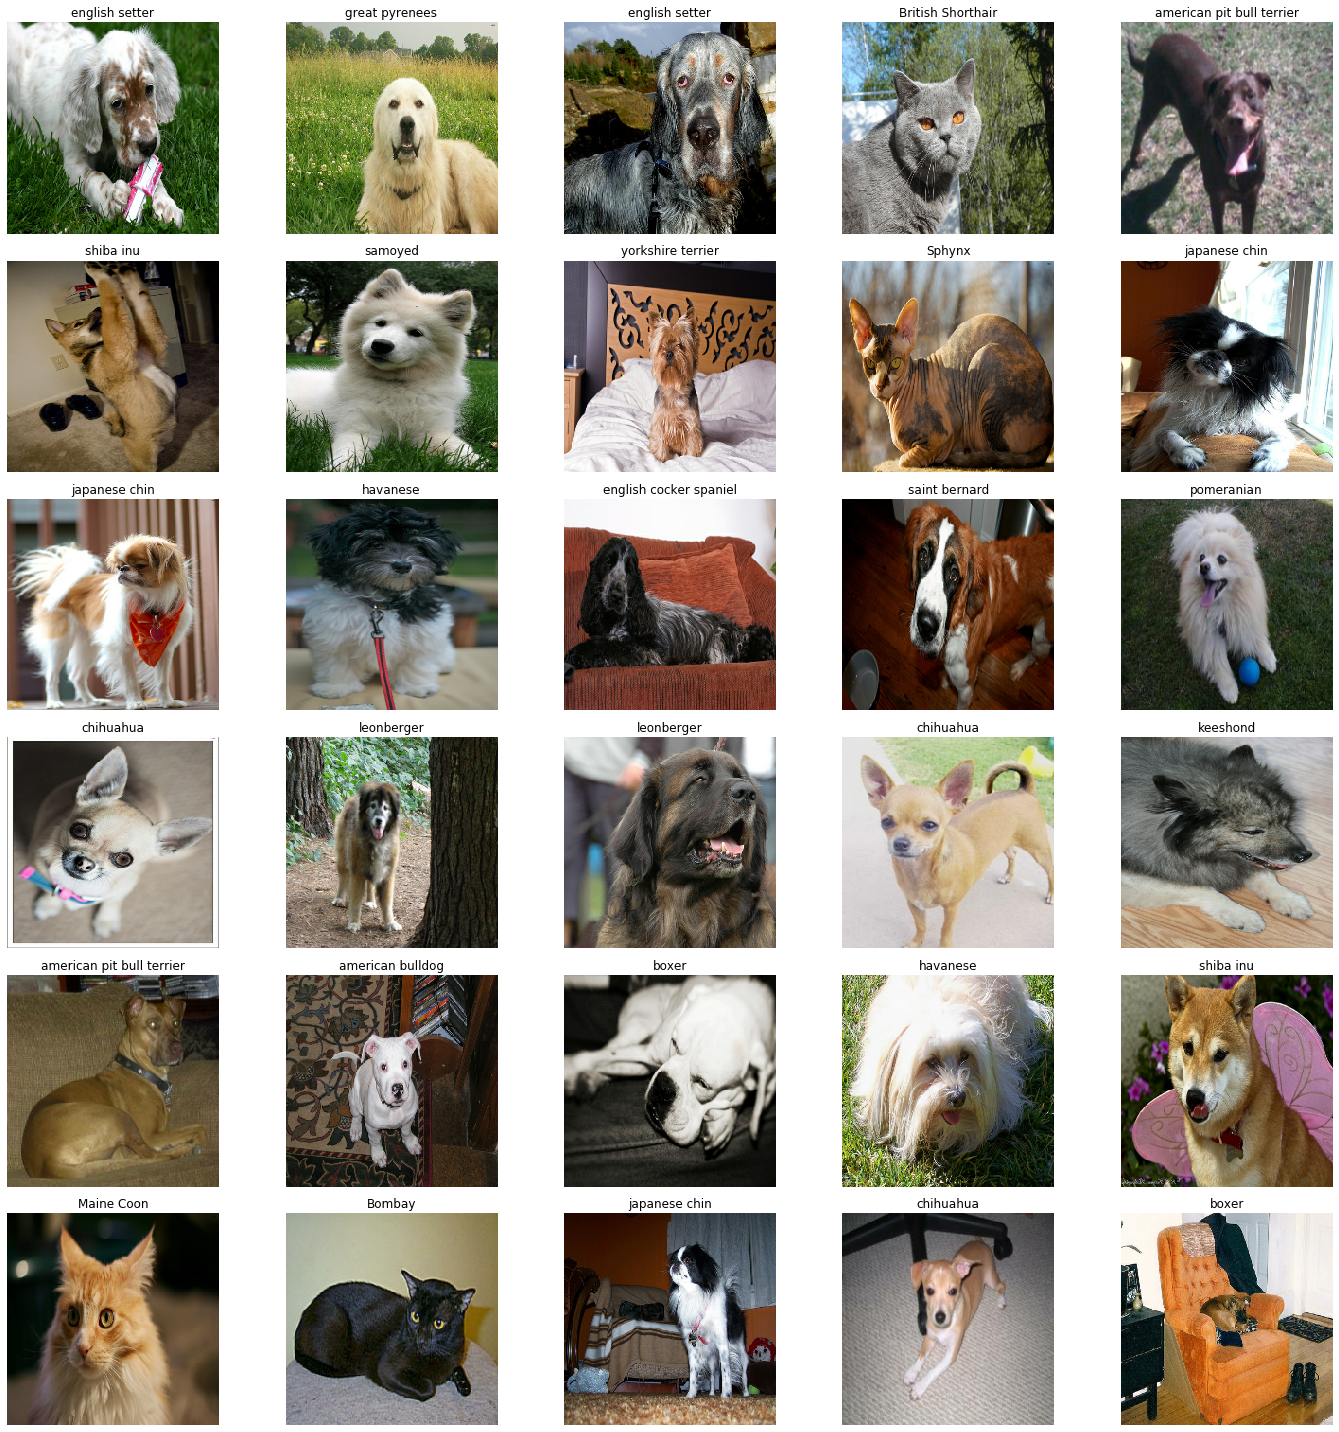

In [6]:
def generate_name_id_pairs(datapoint):
    name = datapoint['file_name']
    label = datapoint['label']
    return name, label

name_id_pairs = raw_train.map(generate_name_id_pairs)

feat_dict = {}
for name, label in name_id_pairs:
    feat_dict[label.numpy()] = ' '.join(name.numpy().decode("utf-8").split('_')[:-1])

def plotImages(batch):
    img, label = batch
    
    plt.figure(figsize=(20,20))
    
    for n in range(30):
        
        plt.subplot(6,5,n+1)
        plt.imshow(img[n])
        plt.title(feat_dict[label[n].numpy()])
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

sample_train_batch = next(iter(train))
plotImages(sample_train_batch) 


## 6) Prepare model:

Here we actually prepare our model.

First we fetch the feature vector from tensorflow hub. There are many to choose from but here we grab a mobilnet_v2_140_224. It is extracted from a mobilenetV2 model trained on 224x224 ImageNet images with a depth multiplier of 1.4. The magntitude of the depth multiplier corresponds to the number of features in the convolutional layers with 1.4 being the highest available. We set the input shape to include size of our images and the three rgb channels. We also don't want to change any of the weights in our input layer during training so we set it to not be trainable. 

Note that the feature vector is extracted from a model trained on the ILSVRC2012 dataset which is a subset of 1000 classes from ImageNet. Of the 37 pets included in The Oxford-IIIT Pet Dataset dataset 23 of them are in the ILSVRC2012 dataset. That is 21 of the 25 dog breeds and 2 of the 12 cat breeds are in the training set for the feature vector albiet under different labels. This means we will be particularly interested in how this model adapts to the new classes included in the Oxford-IIIT Pet dataset but not the ILSVRC2012 dataset. Here's the list of such classes (remember cats start with a capital letter and dogs do not):

Sphynx,
British Shorthair,
Maine Coon,
Abyssinian,
Bengal,
Egyptian Mau,
Russian Blue,
Ragdoll,
Birman,
Bombay,
havanese,
leonberger,
american bulldog,
shiba inu

We also include a dropout layer to reduce overfitting and add our pediction layer to the top.

In [1]:
OUTPUT_CHANNELS = 3
IMG_SHAPE = (*IMG_SIZE, OUTPUT_CHANNELS)
NUM_CLASSES = info.features['label'].num_classes

feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4"
base_model = hub.KerasLayer(feature_extractor_url, trainable=False, input_shape=IMG_SHAPE)

model = tf.keras.Sequential([
    base_model,
    keras.layers.Dropout(0.25),
    keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

model.summary()

NameError: name 'IMG_SIZE' is not defined

## 7) Prepare training:

We use the Adam optimizer and set it's learning rate to 0.0005 which is half it's default value. Our labels are integers and categorical, so rather than one-hot encode them we can simply use the sparse categorical cross entropy loss. We will use accuracy as our metric to understand how well our models are performing.

In [ ]:
LEARNING_RATE = 0.001*0.5

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## 8) Train model:

We train for 30 epochs amd since we set our training input pipeline to repeat we are required to explicitly state the number of steps per epoch. We also set the number of validation steps in such a way that we have 5 subsplits we average the validation over. 

In [ ]:
EPOCHS = 30

TRAIN_LENGTH = info.splits['train'].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS


history = model.fit(train, 
                    validation_data=test,
                    epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_steps=VALIDATION_STEPS
                    )

## 9) Plot learning curves:

When we plot the accuracy and loss curves for both our training and test sets we can see the model converges very quickly. 

In [ ]:
acc  = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.6, 1.01])
plt.plot([EPOCHS-1,EPOCHS-1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([-0.01, 1.5])
plt.plot([EPOCHS-1,EPOCHS-1])
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


## 10) Evaluation of predictions:

Here we evaluate our predictions. In particular we will observe how well our model adapts to the new classes not included in the training of the feature vector and how well it predicts dogs vs cats. 

In [ ]:
def plotPredictedImages(batch, pred, title):
    img, label = batch
    
    plt.figure(figsize=(10,10))
    plt.suptitle(title, fontsize='xx-large', y=1.05)
    plt.subplots_adjust(hspace=0.5)
    
    for n in range(12):
        
        plt.subplot(3,4,n+1)
        plt.imshow(img[n])
        p = pred[n]
        l = label[n].numpy()

        if pred[n] == label[n]:
            plt.title(feat_dict[pred[n]], color="green")
        else:
            plt.title(feat_dict[p] + "\n" + " (" + feat_dict[l] + ")", color="red")
        
        plt.axis('off')    

    plt.tight_layout()
    plt.show()

In [ ]:
all_accuracy = model.evaluate(test, verbose = 0)[1]
title = 'All classes\nAccuracy: {0:.2f}%'.format(all_accuracy*100)

sample_test_batch = next(iter(test))
predictions = model.predict_classes(sample_test_batch)
plotPredictedImages(sample_test_batch, predictions, title) 

In [ ]:
NEW_CLASSES_STR = [
    "Sphynx",
    "British Shorthair",
    "Maine Coon",
    "Abyssinian",
    "Bengal",
    "Egyptian Mau",
    "Russian Blue",
    "Ragdoll",
    "Birman",
    "Bombay",
    "havanese",
    "leonberger",
    "american bulldog",
    "shiba inu"
]

inv_feat_dict = {v: k for k, v in feat_dict.items()}

NEW_CLASSES = tf.constant(
    [inv_feat_dict[i] for i in NEW_CLASSES_STR], 
    dtype=tf.int64)

test_new = test.unbatch().filter(
    lambda image, label: tf.reduce_any(tf.equal(label, NEW_CLASSES))
).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

test_old = test.unbatch().filter(
    lambda image, label: tf.reduce_all(tf.not_equal(label, NEW_CLASSES))
).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
CATS_STR = list(filter(lambda x: x[0].isupper() , list(inv_feat_dict.keys())))

CATS = tf.constant(
    [inv_feat_dict[i] for i in CATS_STR], 
    dtype=tf.int64)

test_cats = test.unbatch().filter(
    lambda image, label: tf.reduce_any(tf.equal(label, CATS))
).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dogs = test.unbatch().filter(
    lambda image, label: tf.reduce_all(tf.not_equal(label, CATS))
).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
new_accuracy = model.evaluate(test_new, verbose = 0)[1]
title = 'New classes only\nAccuracy: {0:.2f}%'.format(new_accuracy*100)

sample_test_new_batch = next(iter(test_new))
predictions_new = model.predict_classes(sample_test_new_batch)
plotPredictedImages(sample_test_new_batch, predictions_new, title) 

In [ ]:
old_accuracy = model.evaluate(test_old, verbose = 0)[1]
title = 'Old classes only\nAccuracy: {0:.2f}%'.format(old_accuracy*100)

sample_test_old_batch = next(iter(test_old))
predictions_old = model.predict_classes(sample_test_old_batch)
plotPredictedImages(sample_test_old_batch, predictions_old, title) 

In [ ]:
cats_accuracy = model.evaluate(test_cats, verbose = 0)[1]
title = 'Cats only\nAccuracy: {0:.2f}%'.format(cats_accuracy*100)

sample_test_cats_batch = next(iter(test_cats))
predictions_cats = model.predict_classes(sample_test_cats_batch)
plotPredictedImages(sample_test_cats_batch, predictions_cats, title) 

In [ ]:
dogs_accuracy = model.evaluate(test_dogs, verbose = 0)[1]
title = 'Dogs only\nAccuracy: {0:.2f}%'.format(dogs_accuracy*100)

sample_test_dogs_batch = next(iter(test_dogs))
predictions_dogs = model.predict_classes(sample_test_dogs_batch)
plotPredictedImages(sample_test_dogs_batch, predictions_dogs, title)

In [ ]:
import numpy as np
import pandas as pd

labels = np.empty(info.splits['test'].num_examples)
for i, datapoint in enumerate(raw_test.take(-1)):  
    label = datapoint['label'].numpy()
    labels[i] = label
    
predictions = model.predict(test)
predictions = np.argmax(predictions, axis=-1)

cm = tf.math.confusion_matrix(labels, predictions).numpy()

np.fill_diagonal(cm, 0)

top_misclassifications = []
for top_value in sorted((np.unique(cm)), reverse=True):
    if top_value > 5:
        for x in zip(*np.where(cm == top_value)):
            top_misclassifications.append((top_value, feat_dict[x[0]], feat_dict[x[1]]))

pd.DataFrame(top_misclassifications, columns=['# of misclassifications', 'target', 'predicted'])

We can see that accuracy is much higher on breeds already familiar to the feature vector. No suprises here. What might be suprising is how well the model performed on the 14 breeds it had not seen before. The final evaluation was 88.5% accuracy on such breeds. Not only that, but it converged quite quickly and did not require any advanced architecture to achieve these results.  

In [ ]:
model.save('oxford_iiit_pet_model') 

In [10]:
import json
with open('class_dict.json', 'w') as fp:
    str_dict = dict([(str(k), v) for k, v in feat_dict.items()])
    json.dump(str_dict, fp)